<a href="https://colab.research.google.com/github/sznajder/FwdMuonTrigger/blob/master/Plot_FwdMuon_Hits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook to Analyze Forward Muon Hits 

Docs:

https://nbviewer.jupyter.org/github/jiafulow/L1TMuonDocsNov2018/blob/master/emtfpp_description.ipynb#Primitive-conversion





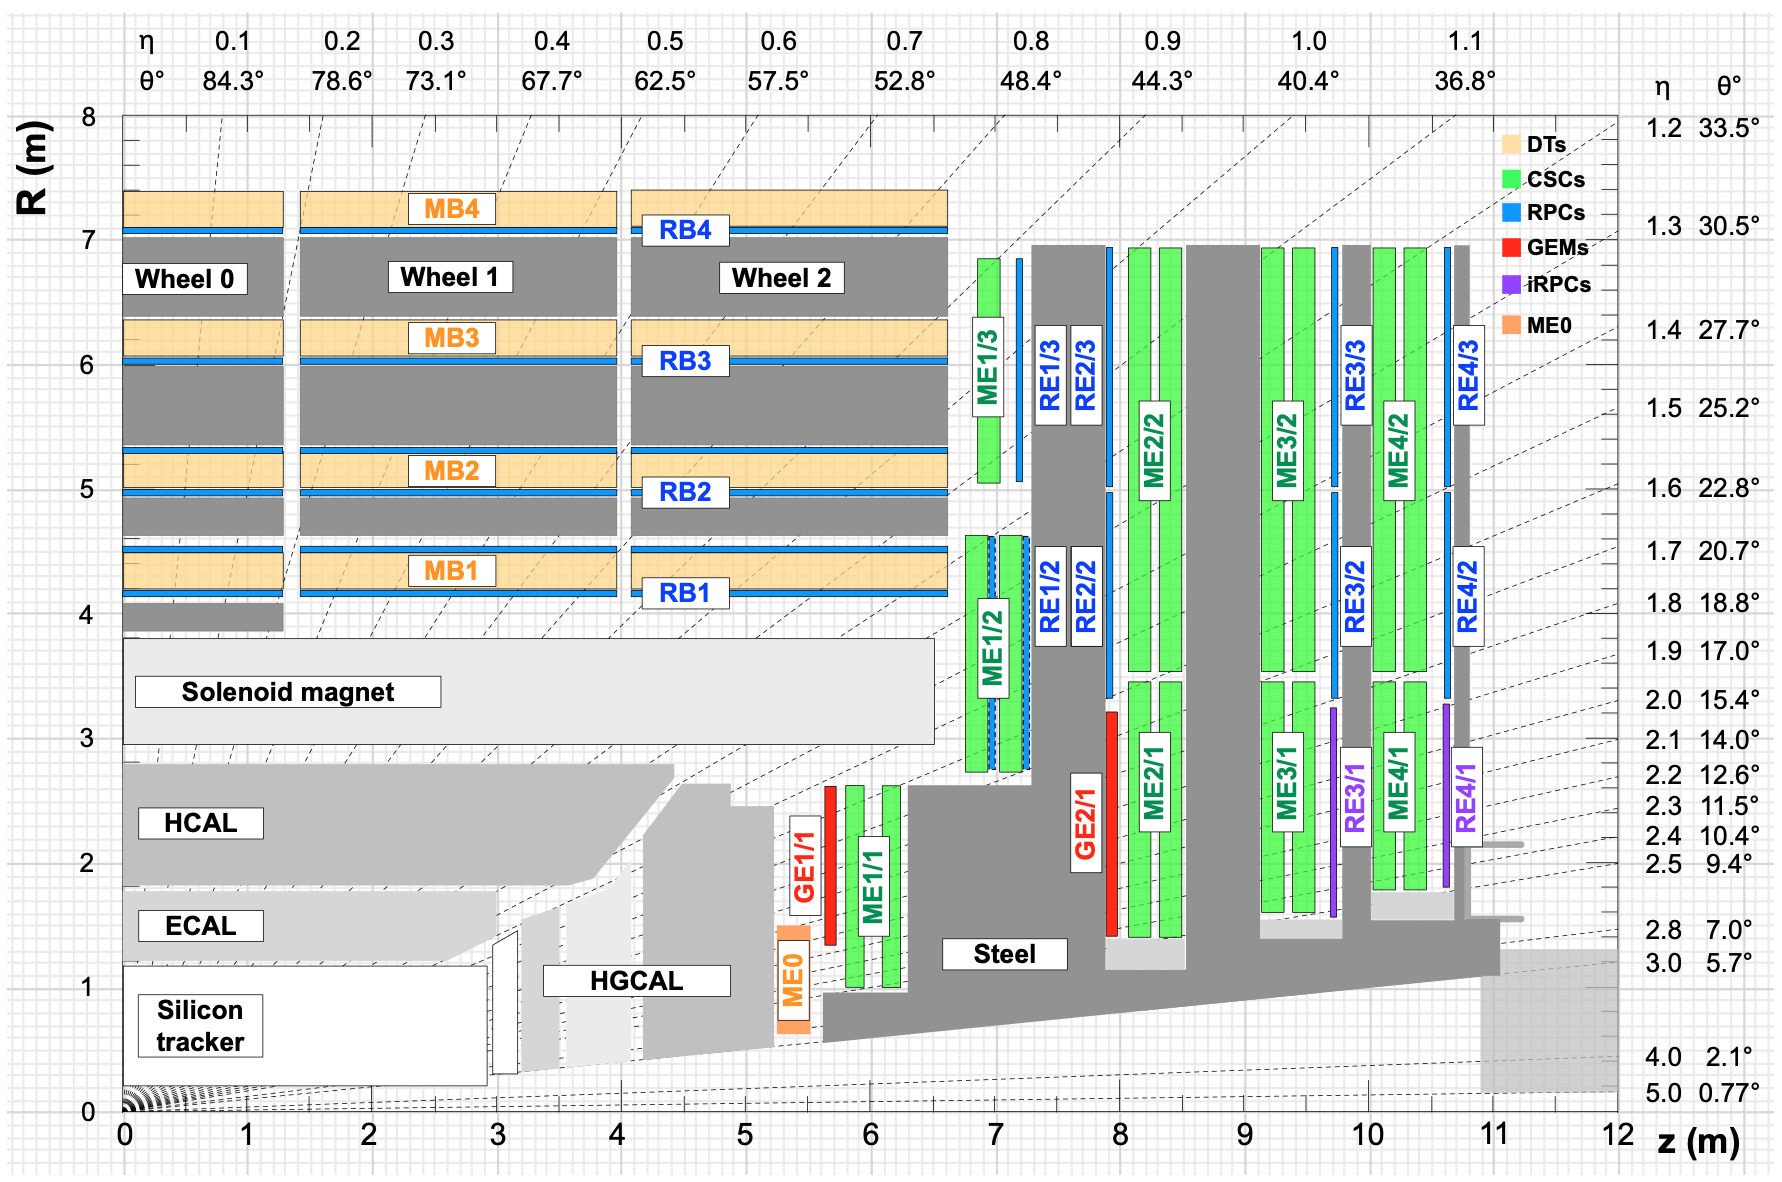


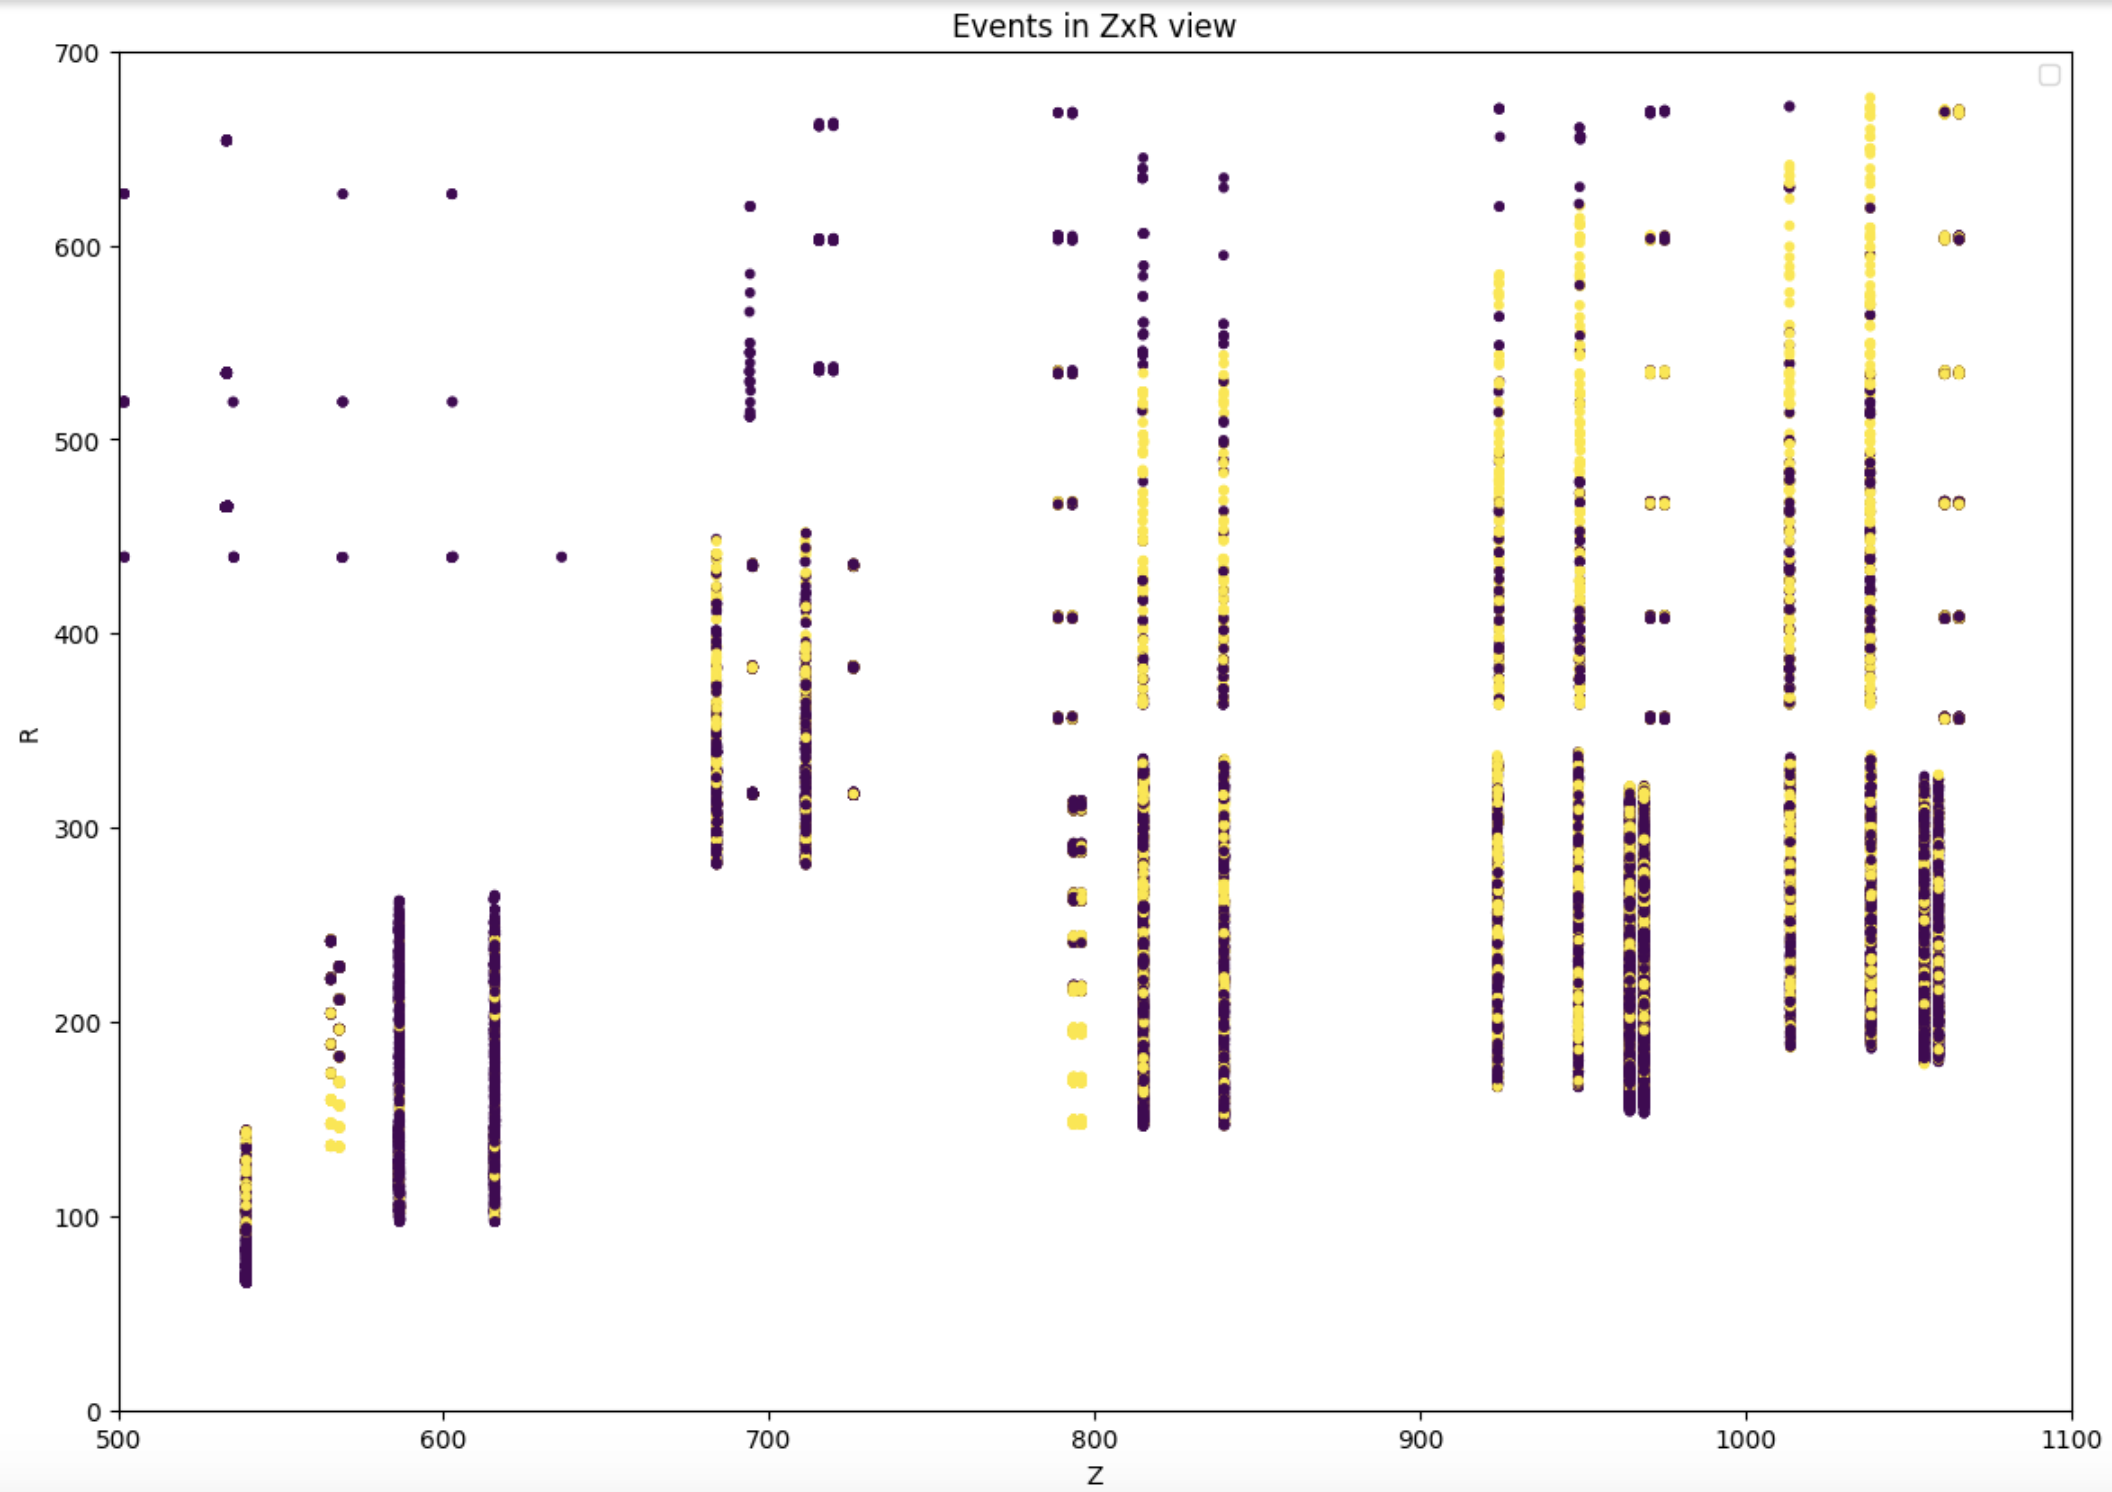



In [1]:
import os
import sys
import numpy as np
import pandas as pd
from collections import namedtuple
import math
import h5py
import random 
import logging
from scipy.sparse import csr_matrix, find
import matplotlib.pyplot as plt
from google.colab import drive

# Mount google drive on remote Colab machine
drive.mount('/content/gdrive', force_remount=False)
sys.path.append('gdrive/My Drive/Colab Notebooks')

!ls 'gdrive/My Drive/Colab Notebooks/Data'
data_dir = 'gdrive/My Drive/Colab Notebooks/Data'

# Input and Output files and events to read
infile_mu   = data_dir+'/ntuple_SingleMuon_Endcap_9.root'
infile_pu = data_dir+'/ntuple_SingleNeutrino_PU200_63.root' 
events_start=0
events_end=1000


# Install uproot
!pip install uproot
import uproot


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
_about.txt	   graphs		  ntuple_qqH_ZZ4mu.root
bolsas_astro.txt   jet_images.h5	  ntuple_SingleMuon_Endcap_9.root
bolsas_fisica.txt  model_best.pt	  ntuple_SingleNeutrino_PU200_63.root
events.root	   ntuple_bkg_ZZ4mu.root  VBFHZZ_background.csv
GOOG.csv	   ntuple_ggH_ZZ4mu.root  VBFHZZ_signal.csv


## Define Globals and Utility Functions

In [0]:
# Event dataframe

pd.set_option('display.max_columns', None)

# Event VARS from Root tree and HITVARS
VARS = ['ve_event','vh_size','vh_type', 'vh_sector','vh_chamber','vh_station', 'vh_ring','vh_sim_r','vh_sim_phi','vh_sim_z', 'vh_sim_eta', 'vh_sim_theta','vh_bend','vh_sim_tp1','vh_sim_tp2']
HITVARS = ['vh_type','vh_sector','vh_chamber', 'vh_station', 'vh_ring','vh_sim_r','vh_sim_phi','vh_sim_z', 'vh_sim_eta', 'vh_sim_theta','vh_bend','vh_sim_tp1','vh_sim_tp2']

# Segments filter cuts
phi_slope_min = 0.
phi_slope_max = 0.0006
z0_max = 1000.



# Muon hit type
#kDT, kCSC, kRPC, kGEM, kME0 = 0, 1, 2, 3, 4

# Muons ZONES in Eta ranges
etabins = [1.2, 1.55, 1.7, 1.8, 1.98, 2.15, 2.5]

# Number of Muon PHI sectors 
nsectors=6

# MUON Detector layers 
nlayers = 12  # 5 (CSC) + 4 (RPC) + 3 (GEM)

# List of Forward Muon detector layer IDs 
csc_layers  = [ 2 , 3 , 7 , 8 , 10 ]
csc_rpc_layers  = [ 2 , 3 , 4 , 5 , 7 , 8 , 9, 10, 11 ]
muon_layers = [ 0, 1, 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 ]

# EMTF hit layer number
#emtf_lut[1,1,4] = 0  # ME1/1a
#emtf_lut[1,1,1] = 0  # ME1/1b
#emtf_lut[1,1,2] = 1  # ME1/2
#emtf_lut[1,1,3] = 1  # ME1/3
#emtf_lut[1,2,1] = 2  # ME2/1
#emtf_lut[1,2,2] = 2  # ME2/2
#emtf_lut[1,3,1] = 3  # ME3/1
#emtf_lut[1,3,2] = 3  # ME3/2
#emtf_lut[1,4,1] = 4  # ME4/1
#emtf_lut[1,4,2] = 4  # ME4/2
#emtf_lut[2,1,2] = 5  # RE1/2
#emtf_lut[2,2,2] = 6  # RE2/2
#emtf_lut[2,3,1] = 7  # RE3/1
#emtf_lut[2,3,2] = 7  # RE3/2
#emtf_lut[2,3,3] = 7  # RE3/3
#emtf_lut[2,4,1] = 8  # RE4/1
#emtf_lut[2,4,2] = 8  # RE4/2
#emtf_lut[2,4,3] = 8  # RE4/3
#emtf_lut[3,1,1] = 9  # GE1/1
#emtf_lut[3,2,1] = 10 # GE2/1
#emtf_lut[4,1,1] = 11 # ME0

emtf_lut = np.zeros((5,5,5), dtype=np.int32) - 99
emtf_lut[1,1,4] = 2  # ME1/1a
emtf_lut[1,1,1] = 2  # ME1/1b
emtf_lut[1,1,2] = 3  # ME1/2
emtf_lut[1,1,3] = 3  # ME1/3
emtf_lut[1,2,1] = 7  # ME2/1
emtf_lut[1,2,2] = 7  # ME2/2
emtf_lut[1,3,1] = 8  # ME3/1
emtf_lut[1,3,2] = 8  # ME3/2
emtf_lut[1,4,1] = 10  # ME4/1
emtf_lut[1,4,2] = 10  # ME4/2
emtf_lut[2,1,2] = 4  # RE1/2
emtf_lut[2,2,2] = 5  # RE2/2
emtf_lut[2,3,1] = 9  # RE3/1
emtf_lut[2,3,2] = 9  # RE3/2
emtf_lut[2,3,3] = 9  # RE3/3
emtf_lut[2,4,1] = 11  # RE4/1
emtf_lut[2,4,2] = 11  # RE4/2
emtf_lut[2,4,3] = 11  # RE4/3
emtf_lut[3,1,1] = 1  # GE1/1
emtf_lut[3,2,1] = 6 # GE2/1
emtf_lut[4,1,1] = 0 # ME0

# Get layer function
def get_layer(dtype, station, ring):
  layer = emtf_lut[dtype.astype(int),station.astype(int),ring.astype(int)] 
  return layer

def muon_layer(dtype, station, ring):
  layer = emtf_lut[dtype.astype(int),station.astype(int),ring.astype(int)] 
  return layer

# Delta phi function
def calc_dphi(phi1, phi2):
    """Computes phi2-phi1 given in range [-pi,pi]"""
    dphi = phi2 - phi1
    dphi[dphi > np.pi] -= 2*np.pi
    dphi[dphi < -np.pi] += 2*np.pi
    return dphi



# Read EVENTS function

In [3]:
# Load the DATA and store selected the Root tree variables into Pandas dataframe
upfile_mu = uproot.open(infile_mu)
upfile_pu = uproot.open(infile_pu)
tree_mu = upfile_mu["ntupler"]["tree"] # dictionary of NumPy arrays
tree_pu = upfile_pu["ntupler"]["tree"] # dictionary of NumPy arrays

upfile_mu.keys()
tree_mu.show()


# Read ROOT trees into dataframes
df_events_mu = tree_mu.pandas.df(VARS,flatten=False, entrystart=int(events_start), entrystop=int(events_end))
df_events_pu = tree_pu.pandas.df(VARS,flatten=False, entrystart=int(events_start), entrystop=int(events_end))
df_muon_vp   = tree_mu.pandas.df(['vp_pt','vp_eta'], entrystart=int(events_start), entrystop=int(events_end))


vh_endcap                  TStreamerSTL               asjagged(asdtype('>i2'), 10)
vh_station                 TStreamerSTL               asjagged(asdtype('>i2'), 10)
vh_ring                    TStreamerSTL               asjagged(asdtype('>i2'), 10)
vh_sector                  TStreamerSTL               asjagged(asdtype('>i2'), 10)
vh_subsector               TStreamerSTL               asjagged(asdtype('>i2'), 10)
vh_chamber                 TStreamerSTL               asjagged(asdtype('>i2'), 10)
vh_cscid                   TStreamerSTL               asjagged(asdtype('>i2'), 10)
vh_bx                      TStreamerSTL               asjagged(asdtype('>i2'), 10)
vh_type                    TStreamerSTL               asjagged(asdtype('>i2'), 10)
vh_neighbor                TStreamerSTL               asjagged(asdtype('>i2'), 10)
vh_strip                   TStreamerSTL               asjagged(asdtype('>i2'), 10)
vh_wire                    TStreamerSTL               asjagged(asdtype('>i2'), 10)
vh_r

## Get HITS Function

In [0]:
# Function that builds a HITS dataframe per event containing all real muon hits and merge it with pileup hits
def getHits(event_mu,event_pu):

 # print("event_mu = ", event_mu.head())

  # Create a HITS dataframe for a given muon event 
  hits_mu = event_mu[HITVARS]        # create a DF containing only muon hits variables
  hits_mu_list = hits_mu.values.tolist()  # evaluate jagged arrays and transform to list or arrays DF ( trick for DF of jagged arrays )
  df_hits_mu = pd.DataFrame(hits_mu_list, index=hits_mu.index) # create a dataframe from a list of arrays
  df_hits_mu = df_hits_mu.transpose() # transpose dataframe to have hit variables as columns 

  # Get only true muon hits (use generator-level matching condition)!
  df_hits_mu = df_hits_mu[(df_hits_mu['vh_sim_tp1']==0) & (df_hits_mu['vh_sim_tp2']==0)]   

  # Create a HITS only dataframe for a given pileup event 
  hits_pu = event_pu[HITVARS]         # create a DF containing only pileup hits variables
  hits_pu_list = hits_pu.values.tolist()   # evaluate jagged arrays and transform to list or arrays DF ( trick for DF of jagged arrays )
  df_hits_pu = pd.DataFrame(hits_pu_list, index=hits_pu.index)   # create a dataframe from a list of arrays
  df_hits_pu = df_hits_pu.transpose() # transpose dataframe to have hit variables as columns

  # Add "isMuon" variable to dataframes
  nmu = len(df_hits_mu)
  npu = len(df_hits_pu)

  # If empty events rerurn empty dataframes 
  if (nmu+npu==0) : return pd.Dataframe(HITVARS)

  df_hits_mu['isMuon'] = np.ones(nmu)
  df_hits_pu['isMuon'] = np.zeros(npu)
  
  # Concatenate MUON and PU hits dataframes into a single hits dataframe
  df_hits = pd.concat([df_hits_mu, df_hits_pu],ignore_index=True) # merge muon and pileup hits
#  df_hits = df_hits_mu # only muon hits
 
#  print("df_hits head=",df_hits.head())

  # Add hit layer info to dataframe
  df_hits['vh_layer'] = df_hits.apply(lambda row: get_layer(row['vh_type'], row['vh_station'], row['vh_ring']), axis=1)
 
  # Filter out hits without layer information
  #df_events_mu = df_events_mu[(df_events_mu["vh_layer"]>=0)]
  #df_events_pu = df_events_pu[(df_events_pu["vh_layer"]>=0)]

  #print("len(df_hits)=",len(df_hits))
  #print("df_hits head = ", df_hits.head(3) ) 

  # Filter odd hits
#  df_hits = df_hits[df_hits['vh_chamber']%2==0] 
#  print( df_hits[['vh_type','vh_station','vh_layer','vh_sector','vh_chamber', 'vh_ring','vh_sim_r','vh_sim_z']] )

  # Add the muon event number to the hits dataframe ( hits history )
  evtid = event_mu['ve_event'][0]        # muon event number
  df_hits["evtid"]=evtid
 
  # Return the HITS dataframe 
  return df_hits
  

## Plot FWD Muon Detector Radiography using HITS

In [0]:
# Plot hits
def plotHits(df_hits):

  plt.figure(figsize=(14, 10),dpi=100)
  
  hittype = df_hits.vh_type.to_numpy()

  # Convert PHI from degrees to radians
  phi = df_hits.vh_sim_phi.to_numpy()* np.pi/180.

  # Get hits transverse cartesian coordinates XxY 
  Z=df_hits.vh_sim_z.to_numpy()
  R=df_hits.vh_sim_r.to_numpy()
  Y=R*np.sin(phi)
  X=R*np.cos(phi)

  # Set MUON and PILEUP hits colors
#  hitcolor = df_hits.isMuon.to_numpy()+1
  hitcolor = hittype*10
# cmap = colors.ListedColormap(['k','b','y','g','r'])

  # Transform 0 and 1 labels into color list using the dictionary 
  # kDT, kCSC, kRPC, kGEM, kME0 = 0, 1, 2, 3, 4
  colordic={0:'yellow', 1:'green', 2:'blue', 3:'red', 4:'orange'}
  cl=[colordic.get(n) for n in hittype ] # color according to hit type


  # Plots in transverse XxY plane 
#  plt.scatter(X, Y,c=hitcolor , s=10. )
  plt.scatter(X, Y,color=cl , s=10. )
  
  plt.title('Events XxY view')
  plt.xlim(-600,600)
  plt.ylim(-600,600)
  plt.xlabel('X')
  plt.ylabel('Y')
  plt.legend()
  plt.show()

  plt.figure(figsize=(14, 10),dpi=100)

#  plt.scatter(Z,R,c=hitcolor , s=10.)
  plt.scatter(Z,R,color=cl , s=10.)

  plt.xlim(500,1100)
  plt.ylim(0,700)
  plt.xlabel('Z')
  plt.ylabel('R')
  plt.legend()
  plt.title('Events in ZxR view')
  plt.show()
  
  return

## MAIN program


Initializing random seed=1


No handles with labels found to put in legend.


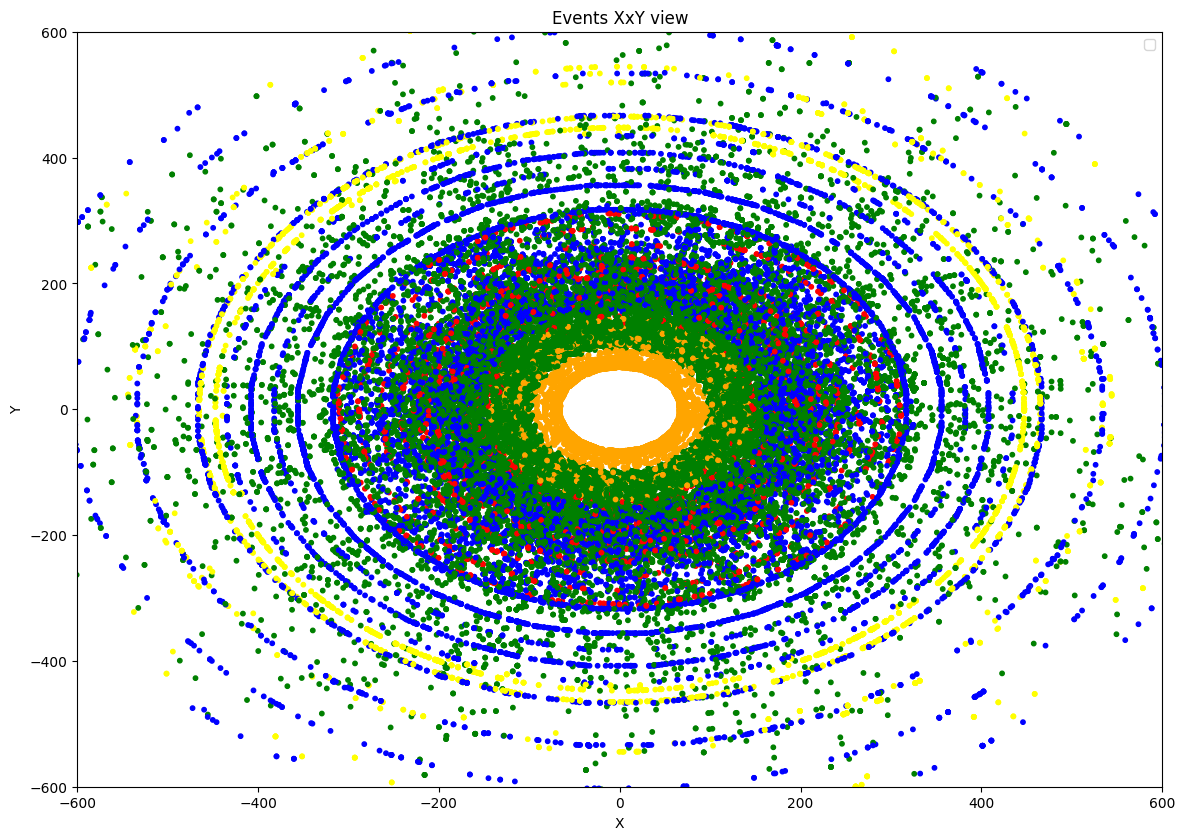

No handles with labels found to put in legend.


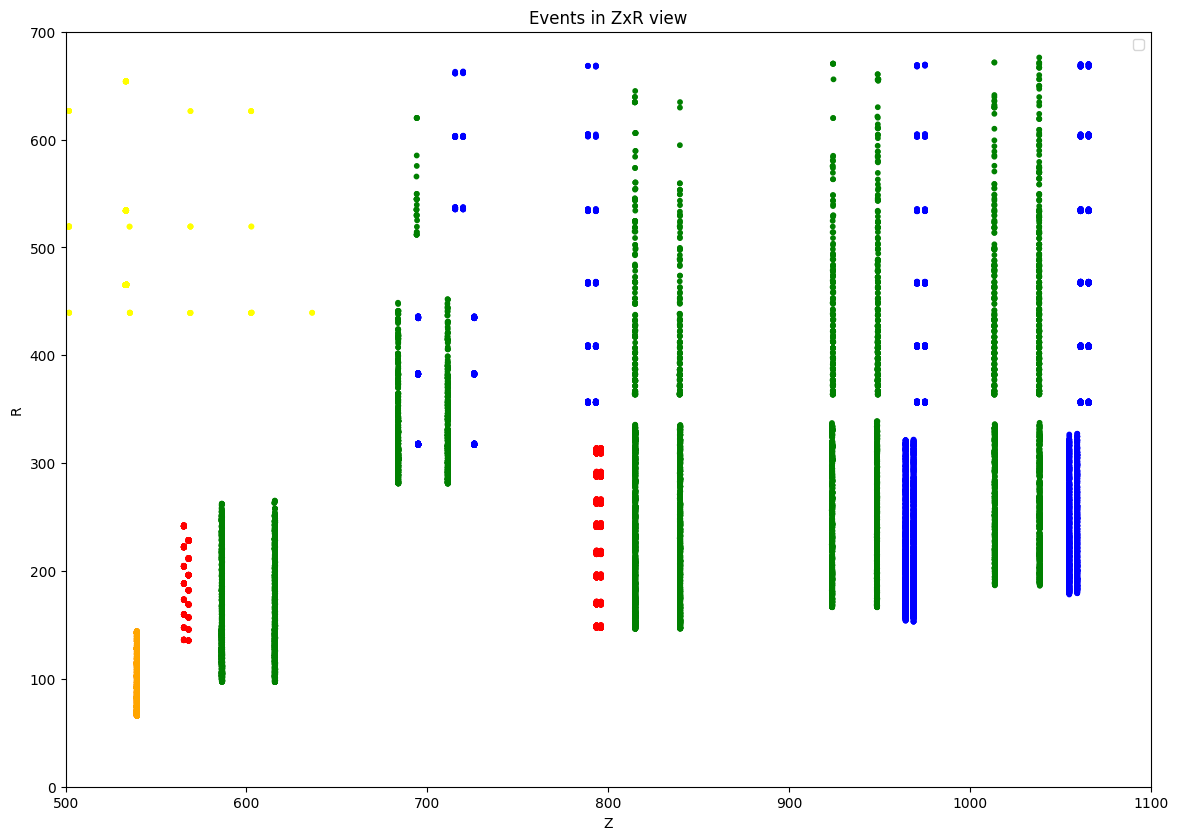

In [6]:
# Initialize the random number generator
print('Initializing random seed=1')
random.seed(1)

# Get number of events in dataframes
nmu = len(df_events_mu)
npu = len(df_events_pu)

# Plot the detector Radiography using hits


hits = []

# Loop over muon events mu 
for imu, event_mu in df_events_mu.iterrows():

  # Pick a random pu event 
  ipu = random.randint(0,npu-1)
  event_pu = df_events_pu.iloc[ipu] 

  # Get event hits
  df_hits = getHits(event_mu,event_pu)
  hits.append(df_hits)

# Concatenate HITS dataframes
df_hits = pd.concat( hits, ignore_index=True)

# Plot hits
plotHits(df_hits)
